# Analytic neural networks

On the last 2 classes of [MO810](https://www.ic.unicamp.br/~meidanis/courses/mo810/2018s1/), we expanded the cost function of a neural network for it's training data, calculated it's partial derivative for each parameter being optimized and finally used these derivatives to implement a gradient descent to optimize the function. 

1000s of iterations later, we had a reasonably trainned model.

Doing all this work analytically instead of numerically is something that caught my attention: It's a lot of work (and really not pratical for anything vaguely complex), but it's an excelent exercise.

Now, humans suck at making expansions and derivatives. It takes a lot of time, and there will most certainly be a mistake at the end. [SymPy](https://simpy.readthedocs.io), on the other hand, is _perfect_ for this.

So, this notebook receives a dataset and a SimPy expression and does it all magically.

Dataset inputs are mapped to the symbols $x_i$, and all remaining symbols are considered variables to optimized (By convention, $w_i$ is used for coefficients and $b_i$ is used for constants)

Finally, at the end of the file, I used this to fit a 3-neurol, 2-layer neural network with a logistic activation function to fit the XOR function

In [1]:
from IPython.display import HTML, display, display_html

class Table:
    """ Just a component to display tabular data on Jupyter """
    
    def __init__(self, headers, header_exprs):
        self.headers = headers
        self.header_exprs = header_exprs
        self.data = []
        
    def append(self, row):
        self.data.append(row)
    
    def _repr_html_(self):
        html = ["<table>"]
        html.append("<tr>")
        for header, expr in zip(self.headers, self.header_exprs):
            html.append(f'<th title="{expr}">{header}</th>')
        html.append("</tr>")
        for row in self.data:
            html.append("<tr>")
            for cell in row:
                html.append(f"<td>{cell}</td>")
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [2]:
import sympy

class SymbolVectorMetaclass(type):
    def __getattr__(cls, key):
        return cls(key)

        
class SymbolVector(metaclass = SymbolVectorMetaclass):
    """
    And infinite array of symbols.
    
    SymbolVector.x yields [x_0, x_1, x_2, ...]
    """
    def __init__(self, name):
        self.name = name

    @staticmethod
    def __getattr__(cls, key):
        return Vector(key)
        
    def __getitem__( self, key ) :
        if isinstance( key, slice ) :
            if (key.start is not None and key.start < 0) or (key.stop is not None and key.stop < 0):
                raise IndexError("Negative indexes are not supported")
            return [self[ii] for ii in range(*key.indices(sys.maxsize))]

        elif isinstance(key, int):
            if key < 0:
                raise IndexError("Negative indexes are not supported")
            return sympy.Symbol(f'{self.name}_{key}')

        else:
            raise TypeError("Invalid argument type.")
    
    def __repr__(self):
        return self.name + '[]'


In [3]:
import random
import re
import sympy
import sys
sympy.init_printing()

def optimize(function_name, function, data, step=0.1, iterations=5000, simplify=True):
    """
    This is where the magic happens:
    - Expand the function and data into a cost function for the dataset
    - Calculate partial derivatives of the cost for each parameter
    - Perform a gradient descent to optimize the function to fit the data
    - Returns the fitted function
    """
    
    display(HTML(f'<h1>Optimizing Function {function_name}</h1>'))
    
    display(HTML(f'<h2>Function:</h2>'), function)

    # Calculate cost function for the dataset, and partial derivatives for each parameter

    x = SymbolVector.x[:len(data[0]['X'])]
    cost_symbol = sympy.Symbol("cost")
    cost = sum([
        (function.subs(zip(x, row['X'])) - row['Y']) ** 2    
        for row in data
    ])
    if simplify:
        cost = sympy.simplify(cost)
    
    display(HTML(f'<h2>Cost:</h2>'), cost)

    optimization_parameters = sorted(list(cost.free_symbols), key=str)

    cost_derivates = [
        sympy.diff(cost, parameter)
        for parameter in optimization_parameters
    ]
    if simplify:
        cost_derivates = [
            sympy.simplify(x)
            for x in cost_derivates
        ]

    cost_fast = sympy.lambdify(optimization_parameters, cost)
    cost_derivates_fast = [
        sympy.lambdify(optimization_parameters, expr)
        for expr in cost_derivates
    ]
    
    # display(HTML(f'<h2>Cost derivatives:</h2>'), *cost_derivates)

    # Optimize equation with gradient descent -- Initial values are random noise
    
    w = [
        random.gauss(0,1) 
        for symbol in optimization_parameters
    ]

    table = Table(
        ['loop'] + optimization_parameters + [sympy.Derivative(parameter, cost_symbol) for parameter in optimization_parameters] + [cost_symbol], 
        [''] + [''] * len(optimization_parameters) + cost_derivates + [cost]
    )

    num_table_rows = iterations // 10
    for i in range(iterations+1):
        gradient = [d(*w) for d in cost_derivates_fast]
        if re.match('^[0-9]0*$', str(i)):
            table.append([i] + w + gradient + [cost_fast(*w)])
            
        w = [
            parameter - step * gradient
            for parameter, gradient in zip(w, gradient)
        ]

    display(HTML(f'<h2>Gradient Descent:</h2>'), table)
    optimized_model = function.subs(zip(optimization_parameters, w))
    optimized_model_fast = sympy.lambdify(x, optimized_model)
    display(HTML(f'<h2>Optimized Function:</h2>'), optimized_model)
    
    display(HTML(f'<h2>Dataset evaluation:</h2>'))
    table = Table(
        x + ['Y', 'Ŷ'],
        [''] * (len(x) + 2)
    )
    for row in data:
        table.append(row['X'] + [row['Y'], optimized_model_fast(*row['X'])])
    display(table)
    return optimized_model


In [4]:
def linear_not():
    data = [
        {'X': [0], 'Y': 1},
        {'X': [1], 'Y': 0},
    ]

    x = SymbolVector.x
    w = SymbolVector.w
    bias = sympy.Symbol("b")
    
    return optimize("NOT (Linear)", x[0]*w[0] + bias, data)

linear_not()

loop,b,w_0,"Derivative(b, cost)","Derivative(w_0, cost)",cost
0,-0.7072294739986593,0.7575384230863372,-3.3138410498219626,0.10061789817535582,2.9171634672480455
1,-0.37584536901646304,0.7474766332688016,-2.008428209528249,0.7432625285046772,2.0310602760138394
2,-0.17500254806363813,0.673150380418334,-1.3537094314178846,0.9962956647093917,1.6287822508357244
3,-0.03963160492184967,0.5735208139473948,-1.011484791792609,1.0677784180510903,1.3658715614663033
4,0.061516874257411244,0.46674297214228583,-0.8204465586857834,1.056519692799394,1.159809042621811
5,0.1435615301259896,0.3610910028623464,-0.7035718737713488,1.009305065976672,0.9881610317316798
6,0.21391871750312447,0.2601604962646792,-0.6240041374581438,0.9481584275356073,0.8426748836186315
7,0.27631913124893887,0.16534465351111843,-0.5640341679820076,0.8833275695201146,0.7187808985648688
8,0.33272254804713963,0.07701189655910697,-0.5150860146932275,0.8194688892124932,0.6131415129814912
9,0.38423114951646237,-0.004934992362142357,-0.47294538665843544,0.75859231430864,0.523036852057852


x_0,Y,Ŷ
0,1,0.999999999999999
1,0,0.0


In [5]:
def linear_xor():
    data = [
        {'X': [0, 0], 'Y': 0},
        {'X': [0, 1], 'Y': 1},
        {'X': [1, 0], 'Y': 1},
        {'X': [1, 1], 'Y': 0},
    ]

    x = SymbolVector.x
    w = SymbolVector.w
    bias = sympy.Symbol("b")
    
    return optimize("XOR (Linear)", x[0]*w[0] + x[1]*w[1] + bias, data)

linear_xor()

loop,b,w_0,w_1,"Derivative(b, cost)","Derivative(w_0, cost)","Derivative(w_1, cost)",cost
0,-0.3372934495964037,-0.6902023983820726,-2.6135546880432687,-19.913375942472598,-11.337092768000442,-15.183797347322836,33.09095629726571
1,1.6540441446508563,0.44350687841797165,-1.0951749533109851,6.625680857634796,4.199854185653342,1.1224905221954282,5.1398344562655325
2,0.9914760588873766,0.023521459852637427,-1.2074240055305279,-0.8038017116125484,-0.35485793610099936,-2.8167488668673304,2.4988070626794374
3,1.0718562300486314,0.059007253462737365,-0.9257491188437947,1.1078823788648222,0.6719556963578855,-1.2975570482551788,1.9372059973387266
4,0.9610679921621492,-0.008188316173051192,-0.7959934140182768,0.47181701653188135,0.21953187591983866,-1.3560783197706128,1.6475857697502871
5,0.9138862905089611,-0.03014150376503506,-0.6603855820412156,0.5489819808466869,0.2142079828932732,-1.0462801736590879,1.4558539531730297
6,0.8589880924242924,-0.05156230205436238,-0.5557575646753068,0.44262527247566297,0.11818803212910656,-0.8902024931127821,1.3237699624266077
7,0.8147255651767261,-0.06338110526727303,-0.46673731536402857,0.3973308388886023,0.0719032089097551,-0.7348092112837559,1.2317278732788668
8,0.7749924812878659,-0.07057142615824855,-0.39325639423565295,0.3446285687273214,0.031171432047163328,-0.6141985041076454,1.1670539709461765
9,0.7405296244151338,-0.07368856936296488,-0.3318365438248884,0.3021365425696567,0.003691132558898802,-0.5126048163649484,1.1212509027196544


x_0,x_1,Y,Ŷ
0,0,0,0.5
0,1,1,0.4999999999999999
1,0,1,0.4999999999999999
1,1,0,0.4999999999999998


In [6]:
def mul_xor():
    data = [
        {'X': [0, 0], 'Y': 0},
        {'X': [0, 1], 'Y': 1},
        {'X': [1, 0], 'Y': 1},
        {'X': [1, 1], 'Y': 0},
    ]

    x = SymbolVector.x
    w = SymbolVector.w
    bias = sympy.Symbol("b")
    return optimize("XOR (With extra nonlinear term x_0*x_1)", x[0]*w[0] + x[1]*w[1] + x[0]*x[1]*w[2]+ bias, data)
    
mul_xor()

loop,b,w_0,w_1,w_2,"Derivative(b, cost)","Derivative(w_0, cost)","Derivative(w_1, cost)","Derivative(w_2, cost)",cost
0,2.170485828954436,-0.8577825800121699,-0.08355309388594907,-0.20592140998575972,9.186701116071493,2.6718639880256463,4.2203229602780885,2.0464574901411146,7.037211890893203
1,1.2518157173472866,-1.1249689788147346,-0.505585389913758,-0.4105671589998712,-1.3288260541354209,-3.3249181436970505,-2.0861509658950967,-1.5786116207621543,3.0168419172247662
2,1.3846983227608287,-0.7924771644450295,-0.2969702933242483,-0.2527059969236557,2.2143847571622075,-0.7304679472326114,0.26054579500895114,0.08508973613579052,2.093179301729701
3,1.1632598470446078,-0.7194303697217683,-0.3230248728251434,-0.26121497053723475,0.6138278650947466,-1.3931617774333986,-0.6003507836401487,-0.2808207320790773,1.7077390563952428
4,1.1018770605351331,-0.5801141919784285,-0.2629897944611285,-0.23313289732932702,0.9763347438641823,-0.9051939093540926,-0.27094511431949253,0.05128035353249816,1.4694585421223705
5,1.004243586148715,-0.4895948010430192,-0.23589528302917928,-0.23826093268257684,0.6554664875357705,-0.8897172910007298,-0.38231825497304994,0.08098513878787911,1.29937313896393
6,0.9386969373951378,-0.4006230719429462,-0.19766345753187428,-0.24635944656136474,0.6237104881390909,-0.7357503463777118,-0.3298311175555678,0.1881019227179051,1.1704369359375653
7,0.8763258885812287,-0.32704803730517507,-0.1646803457763175,-0.26516963883315525,0.513354298657549,-0.6625885641147309,-0.33785318105701545,0.2388557333331618,1.068508826668816
8,0.8249904587154738,-0.26078918089370196,-0.13089502767061595,-0.28905521216647145,0.4550764111335761,-0.5830953683870876,-0.3233070619409155,0.28850207596936894,0.9849157504910346
9,0.7794828176021162,-0.2024796440549932,-0.09856432147652439,-0.31790541976340836,0.39587583916404245,-0.5249267882913733,-0.3170961431344357,0.3210668646143806,0.9141037671292205


x_0,x_1,Y,Ŷ
0,0,0,1.27675647831893e-15
0,1,1,0.9999999999999993
1,0,1,0.9999999999999993
1,1,0,-2.6645352591003757e-15


In [7]:
class Neuron:
    next_b = iter(SymbolVector('b'))
    next_w = iter(SymbolVector('w'))
    
    def __init__(self, inputs, activation_function=None):
        self.x = inputs
        self.w = [next(Neuron.next_w) for input in inputs]
        self.bias = next(Neuron.next_b)
        self.expr = sum([x*w for x,w in zip(self.x, self.w)]) + self.bias
        if activation_function is not None:
            self.expr = activation_function(self.expr)


class NeuralNetwork:
    @staticmethod
    def logistic(expr):
        exp = sympy.functions.elementary.exponential.exp
        return -1 + 2 / (1 + exp(-expr))
    
    def __init__(self, inputs, dims=[], activation_function=None):
        dims = dims + [1]  # Add one last neuron to collect all the results
        self.layers = [inputs]
        
        for dim in dims:
            prev_layer = self.layers[-1]
            self.layers.append([
                Neuron(prev_layer, activation_function).expr
                for i in range(dim)
            ])

        self.expr = self.layers[-1][0]
        
        
#TODO: Draw a neural network

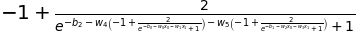

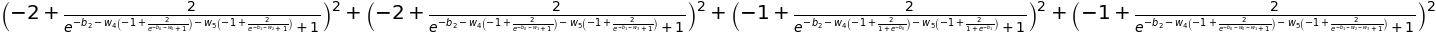

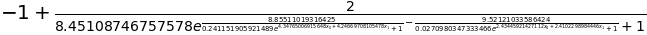

x_0,x_1,Y,Ŷ
0,0,0,0.0005629734354561933
0,1,1,0.9816786832395996
1,0,1,0.9817486562234505
1,1,0,0.0008970341172938046


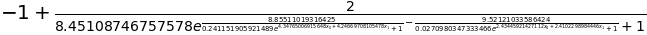

In [8]:
def neural_xor():
    data = [
        {'X': [0, 0], 'Y': 0},
        {'X': [0, 1], 'Y': 1},
        {'X': [1, 0], 'Y': 1},
        {'X': [1, 1], 'Y': 0},
    ]
    x = SymbolVector.x

    neural_network = NeuralNetwork(inputs=x[0:2], dims=[2], activation_function=NeuralNetwork.logistic)
    return optimize("XOR (2 layer net + logistic activation function)", neural_network.expr, data, simplify=False)

neural_xor()    

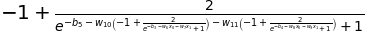

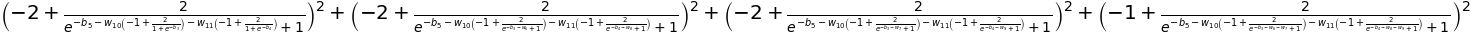

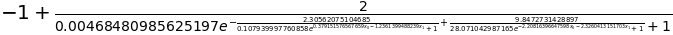

x_0,x_1,Y,Ŷ
0,0,1,0.9983605088602521
0,1,1,0.9861740292963235
1,0,1,0.9858547036318259
1,1,0,0.0005546995610941075


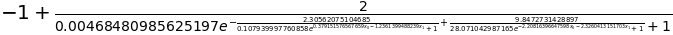

In [9]:
def neural_nand():
    data = [
        {'X': [0, 0], 'Y': 1},
        {'X': [0, 1], 'Y': 1},
        {'X': [1, 0], 'Y': 1},
        {'X': [1, 1], 'Y': 0},
    ]
    x = SymbolVector.x

    neural_network = NeuralNetwork(inputs=x[0:2], dims=[2], activation_function=NeuralNetwork.logistic)
    return optimize("NAND (2 layer net + logistic activation function)", neural_network.expr, data, simplify=False)

neural_nand()    